In [ ]:
# Imports
library(Seurat)
library(SingleCellExperiment)
library(SingleR)
library(celldex)    
library(ggplot2)
library(clustree)
library(stringr) 
library(gridExtra)
library(dplyr)
library(GPTCelltype)
library(openai)

# Change setting for visualizing plots within VSCODE
options(repr.plot.width=20, repr.plot.height=12)

# Read myeloid data
myeloid_data <- readRDS("../../../data/R Objects/Myeloid R Objects/all_humans_myeloid_subset.rds")

Warning message:
"package 'Seurat' was built under R version 4.4.2"
Loading required package: SeuratObject

Warning message:
"package 'SeuratObject' was built under R version 4.4.2"
Loading required package: sp

Warning message:
"package 'sp' was built under R version 4.4.2"

Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, t


Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats

Warning message:
"package 'matrixStats' was built under R version 4.4.2"

Attaching package: 'MatrixGenerics'


The following objects are masked from 'package:matrixStats':

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, 

In [ ]:
# Clustering, we want to choose a lower resolution compared to the processing steps
myeloid_data <- FindNeighbors(myeloid_data, reduction = "integrated.cca", dims = 1:length(which(myeloid_data@reductions$pca@jackstraw$overall.p.values < 0.05)))
myeloid_data <- FindClusters(myeloid_data, resolution = c(0.2, 0.3, 1.2))
myeloid_data <- RunUMAP(myeloid_data, dims = 1:length(which(myeloid_data@reductions$pca@jackstraw$overall.p.values < 0.05)), reduction = "integrated.cca", verbose=FALSE)

Computing nearest neighbor graph



Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23541
Number of edges: 945987

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9123
Number of communities: 8
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23541
Number of edges: 945987

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8953
Number of communities: 10
Elapsed time: 5 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 23541
Number of edges: 945987

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8217
Number of communities: 26
Elapsed time: 5 seconds


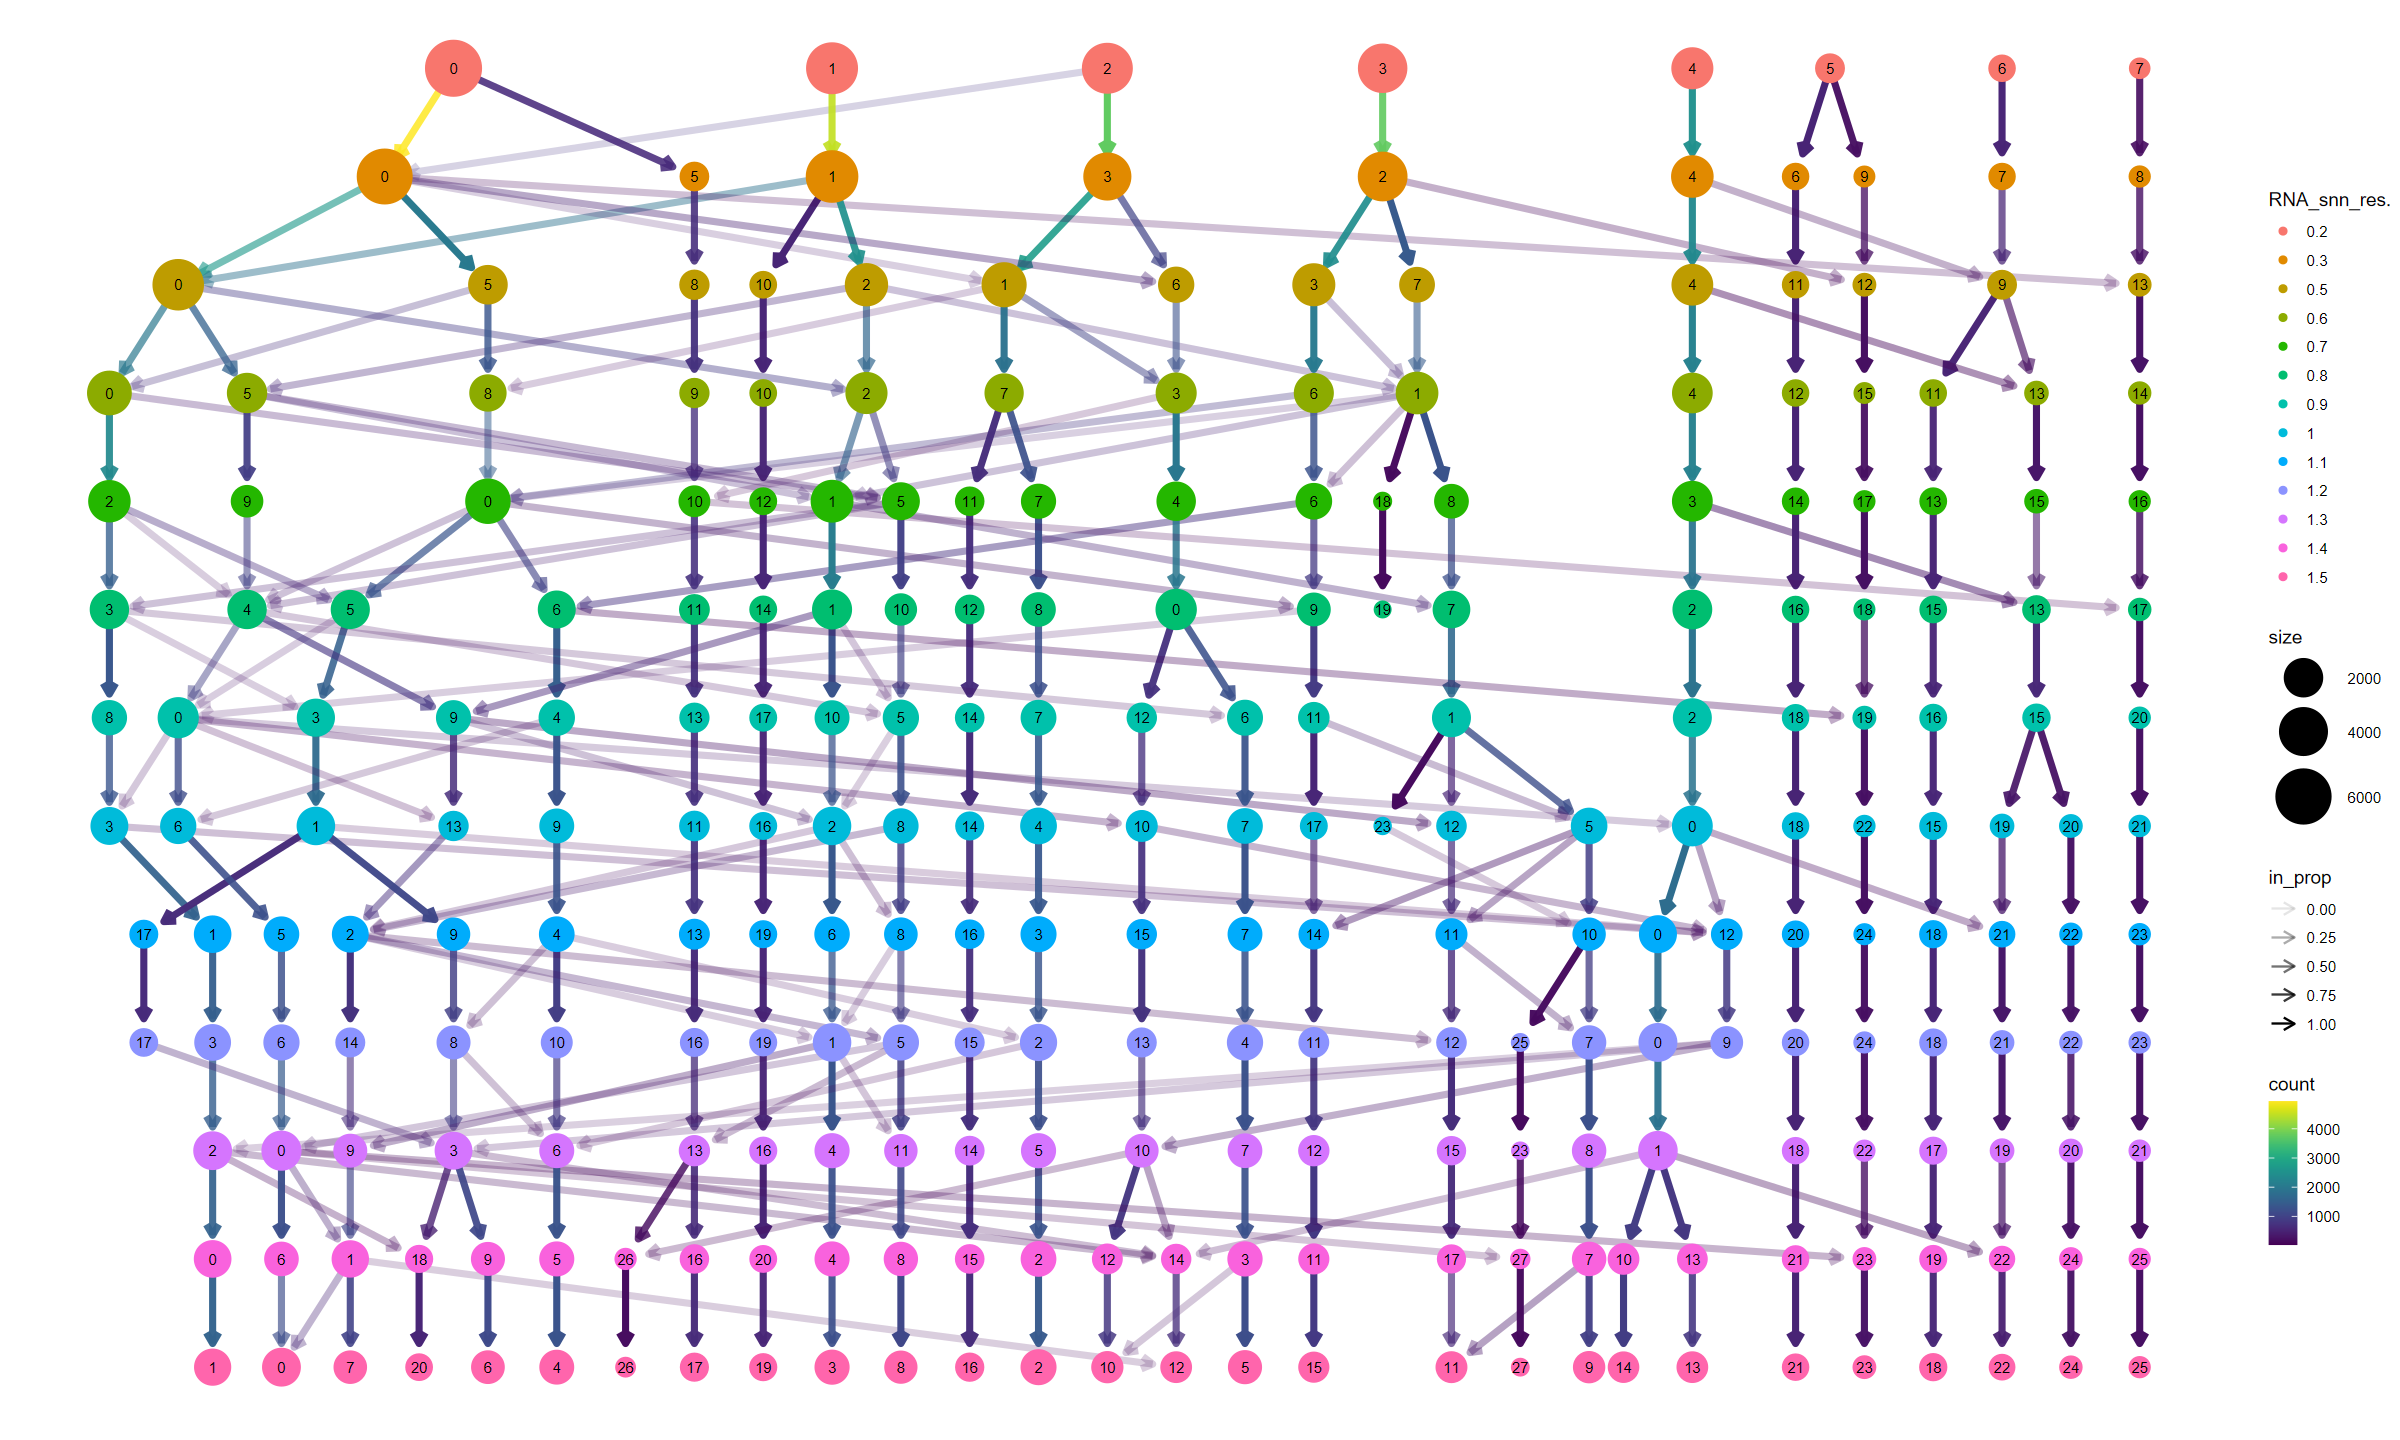

In [18]:
# This cell is meant to analyze the different resolutions and see which one is the best
clustree(myeloid_data, prefix= "RNA_snn_res.", layout = "sugiyama")

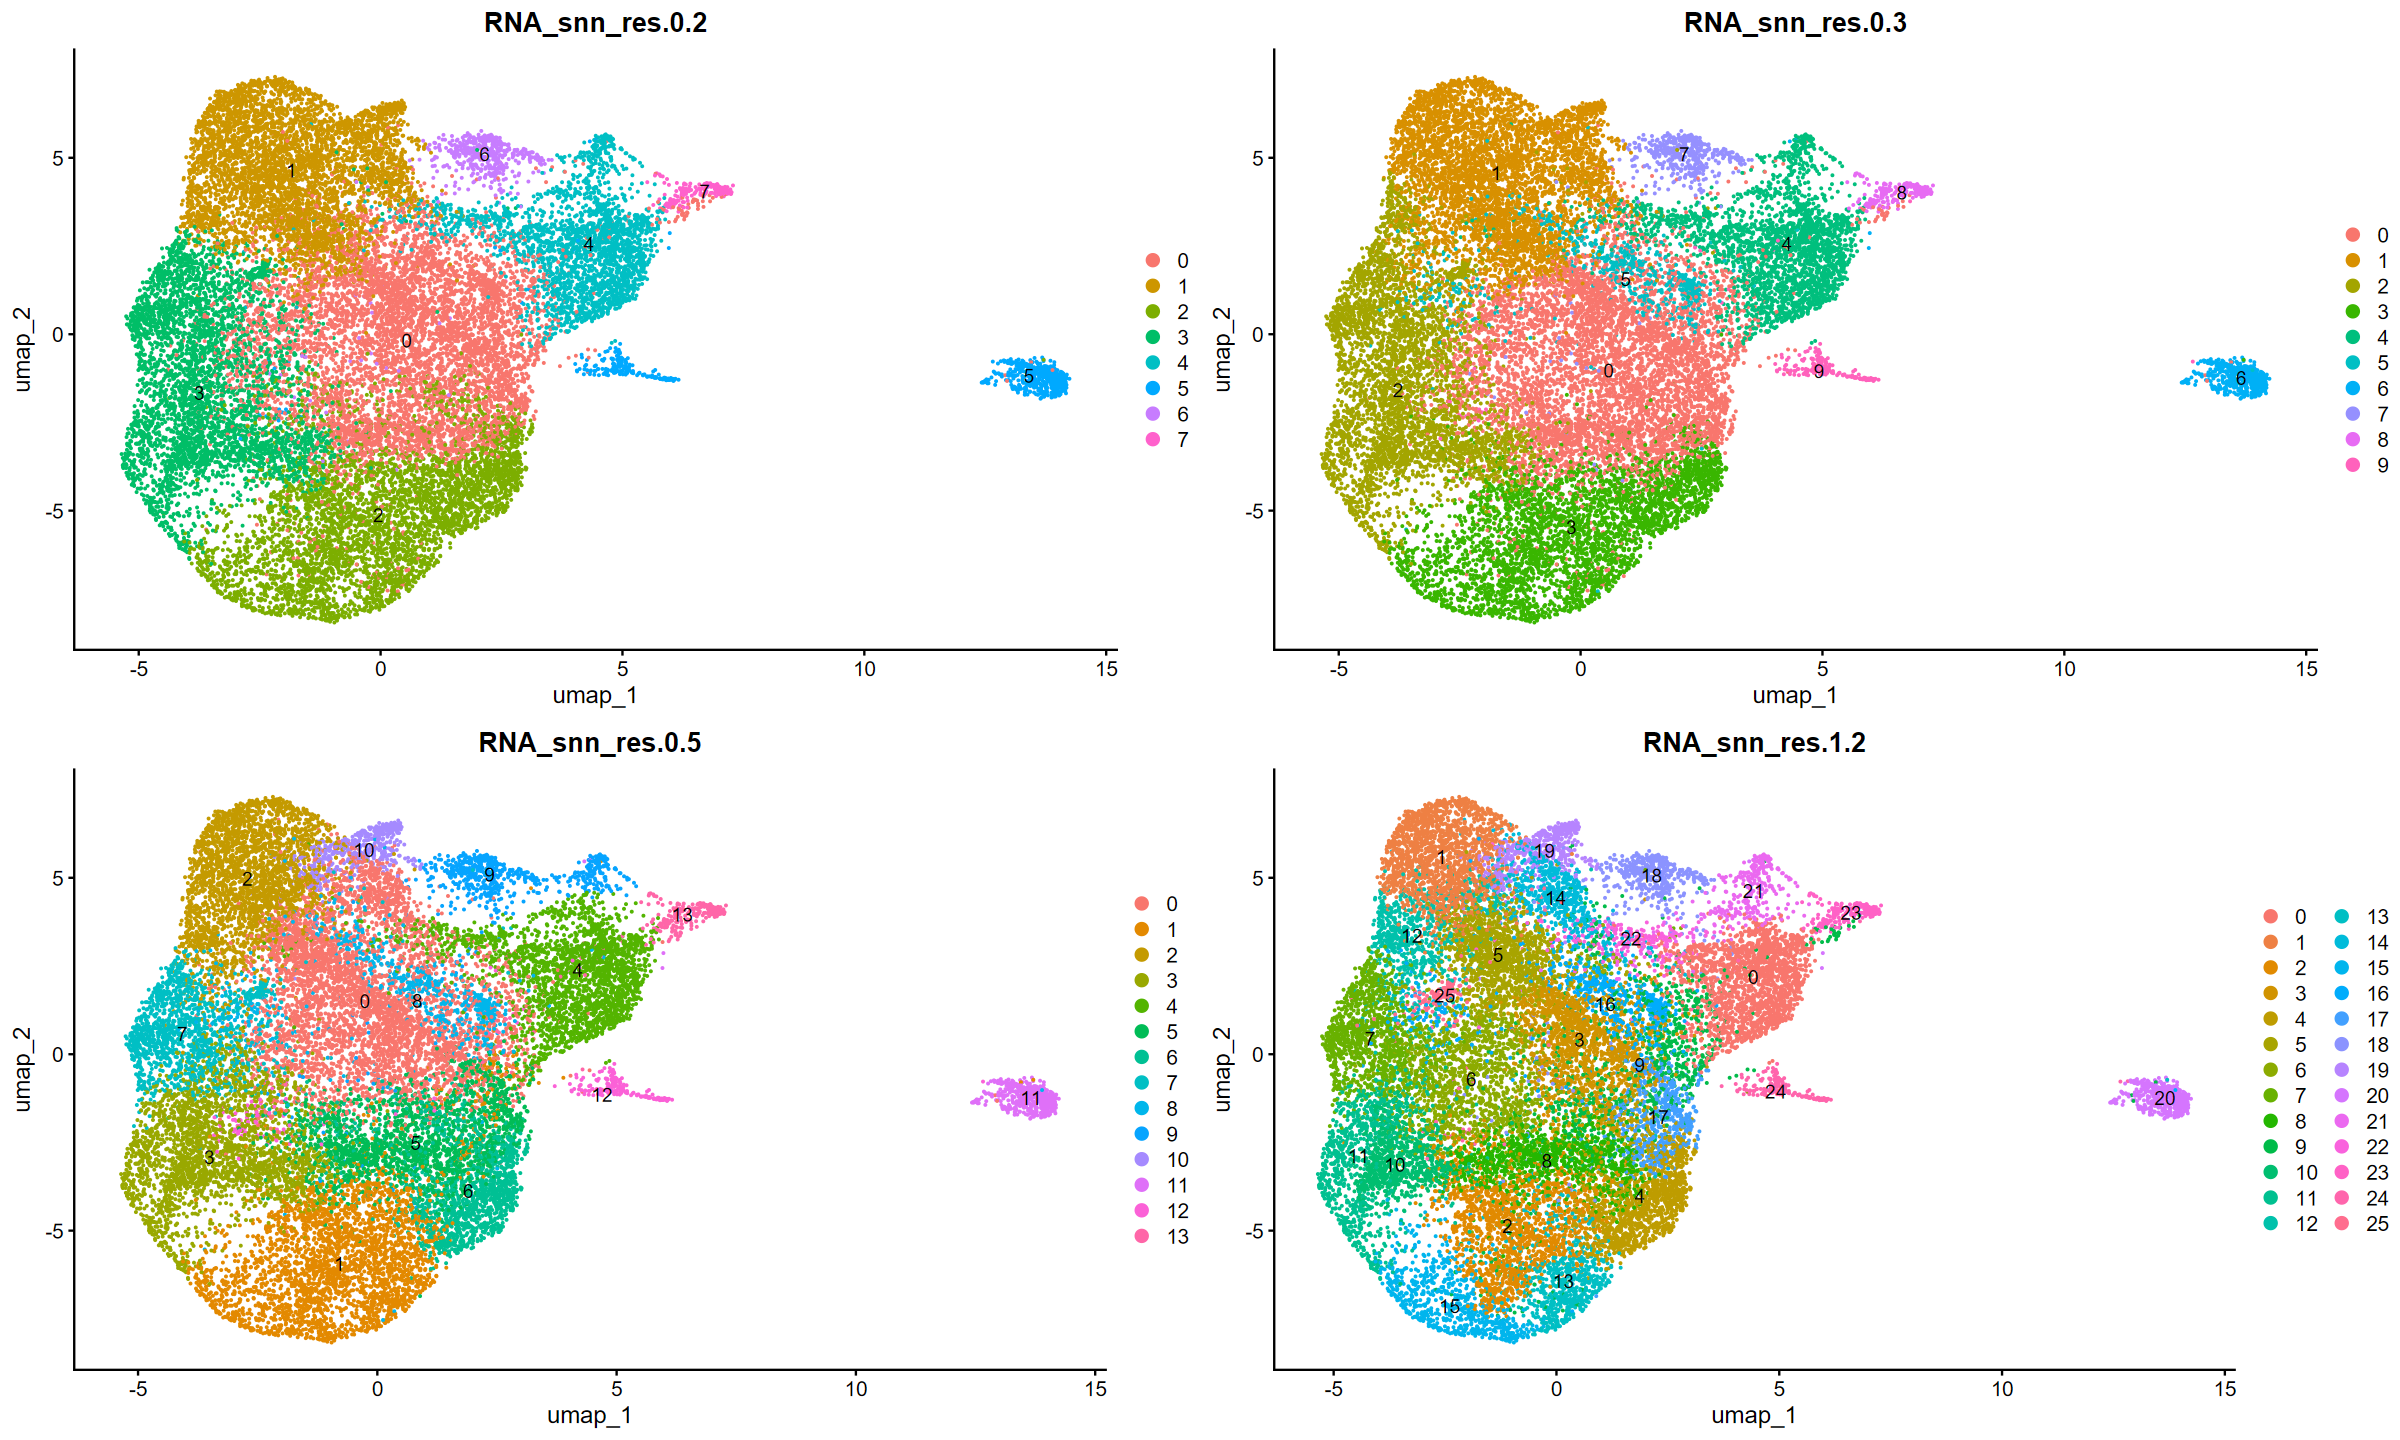

In [ ]:
# Get DimPlots of different resolutions
res_1 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.2", label = T)
res_2 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.3", label = T)
res_3 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.0.5", label = T)
res_4 <- DimPlot(myeloid_data, reduction = "umap", group.by = "RNA_snn_res.1.2", label = T)

# Plot
grid.arrange(res_1, res_2, res_3, res_4, ncol=2)

# Assign resolution
myeloid_data$seurat_clusters <- myeloid_data$`RNA_snn_res.0.3`

In [ ]:
# View distribution of idents before assigning resolution
table(Idents(myeloid_data))

# Assign resolution to identity
myeloid_data <- SetIdent(myeloid_data, value = "RNA_snn_res.0.3")

# View distribution of idents after assigning resolution
table(Idents(myeloid_data))


    Macrophages  Dendritic cell        Mixture1 Dendritic cells       Monocytes 
          18828            2568             698             731             505 
    Mixture2/NA 
            211 


   0    1    2    3    4    5    6    7    8    9 
5913 4947 4186 3782 2568  698  510  505  221  211 

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Warning message in DoHeatmap(myeloid_data, features = top10$gene, size = 1, angle = 0, :
"The following features were omitted as they were not found in the scale.data slot for the RNA assay: AC020914.1, YME1L1, RNMT, SRRM2, KMT2A, AMD1, MALAT1, PALD1"
Warning message in viridisLite::viridis(n, alpha, begin, end, direction, option):
"Option 'blue' does not exist. Defaulting to 'viridis'."
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


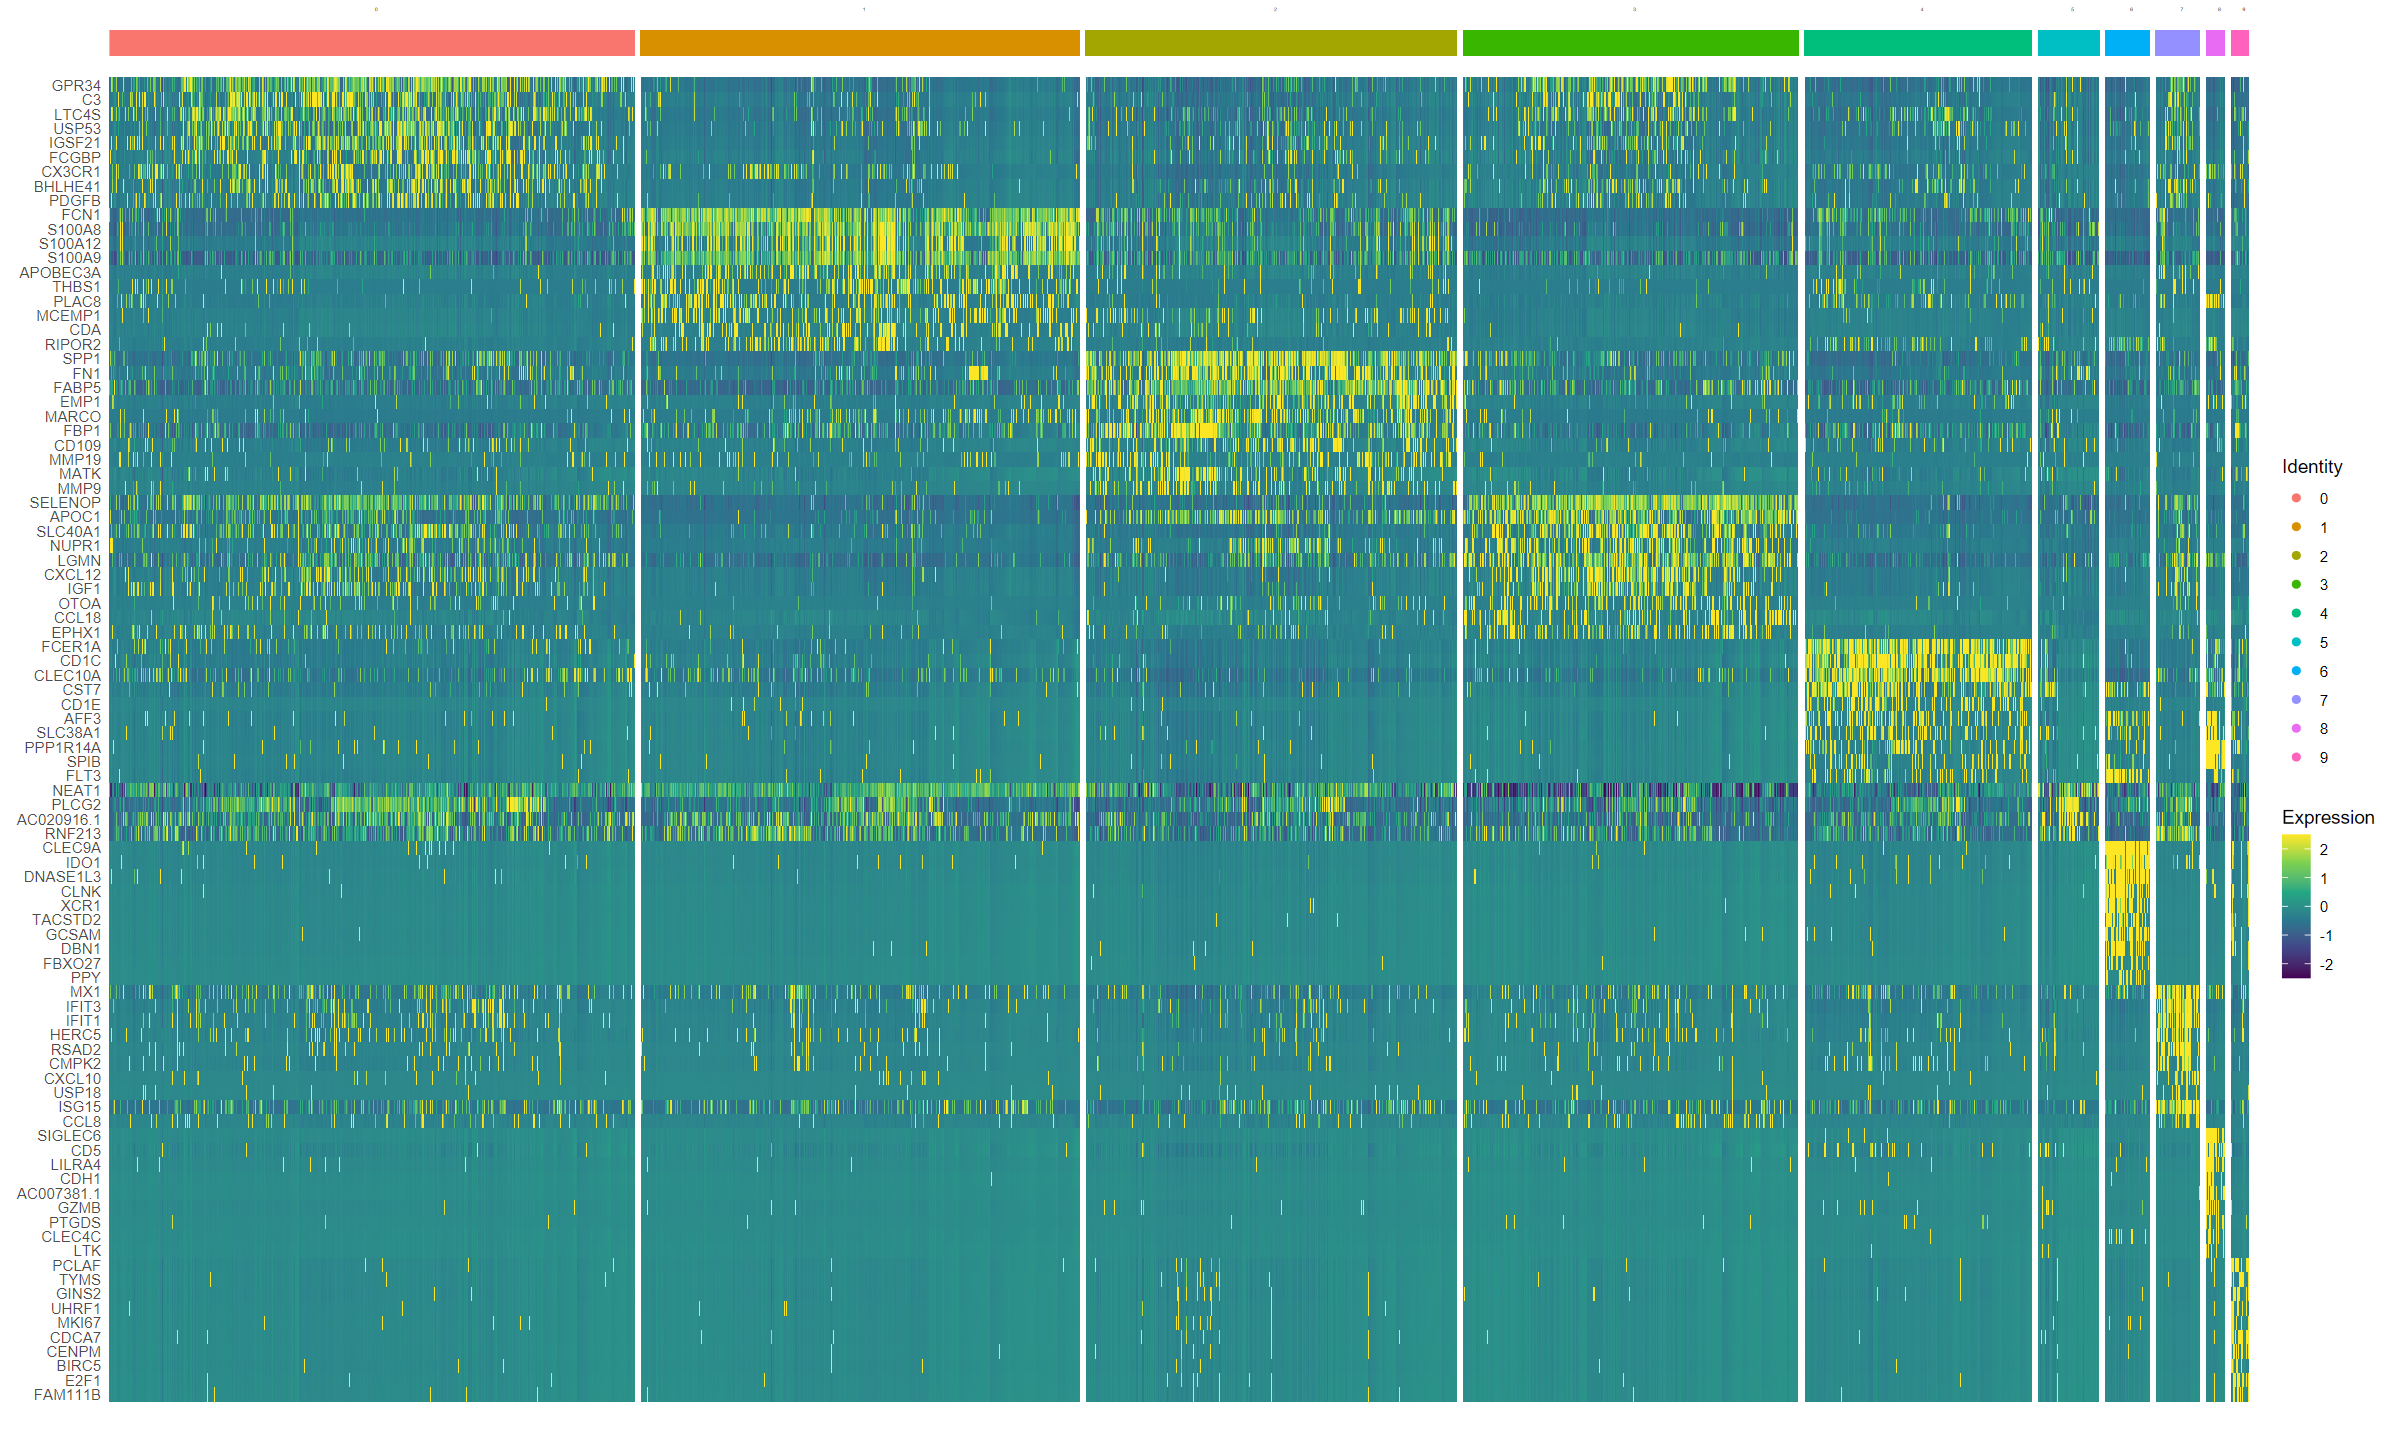

In [ ]:
# Find markers for each cluster
markers <- FindAllMarkers(myeloid_data, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
markers %>%
  group_by(cluster) %>%
  dplyr::filter(avg_log2FC > .75) %>%
  slice_head(n = 10) %>%
  ungroup() -> top10

# Heatmap
top10 <- markers %>% group_by(cluster) %>% top_n(10, avg_log2FC)
DoHeatmap(myeloid_data, features = top10$gene, size=1, angle=0, raster=FALSE) &
  scale_fill_viridis_c(option="blue",na.value = "white")

In [ ]:
# Filter markers
markers %>%  group_by(cluster) %>% filter(as.numeric(as.character(cluster)) > 4) %>% filter(p_val_adj < 0.05) %>% slice_max(order_by = avg_log2FC, n = 10) %>% arrange(cluster, desc(pct.1)) 

p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene      
1  9.496235e-125 1.9078051  0.987 0.932 4.716115e-120 5       MALAT1    
2   2.963451e-54 1.5328780  0.870 0.871  1.471739e-49 5       NEAT1     
3   3.435899e-07 1.0349128  0.394 0.586  1.706371e-02 5       VMP1      
4   6.217855e-10 1.0794408  0.315 0.483  3.087973e-05 5       PABPC4    
5   3.337059e-07 0.8775557  0.288 0.425  1.657284e-02 5       TLR2      
6   1.797949e-09 0.8799217  0.284 0.427  8.929153e-05 5       GK        
7   3.038391e-07 0.8817611  0.219 0.323  1.508956e-02 5       UGP2      
8   1.856595e-07 0.8960226  0.209 0.313  9.220409e-03 5       ADAM17    
9   1.507999e-07 0.9285358  0.173 0.280  7.489174e-03 5       FGD4      
10  6.260542e-11 0.8636012  0.162 0.298  3.109173e-06 5       RNF144B   
11  0.000000e+00 7.7650044  0.933 0.012  0.000000e+00 6       CLEC9A    
12  0.000000e+00 5.9043219  0.863 0.022  0.000000e+00 6       IDO1      
13  0.000000e+00 7.0312760  0.790 0.013  0.000000e+00 6       DNASE1L3  
14  0.000000e+00 7.8271413  0.684 0.004  0.000000e+00 6       CLNK      
15  0.000000e+00 8.5490344  0.676 0.002  0.000000e+00 6       XCR1      
16  0.000000e+00 7.5604595  0.531 0.006  0.000000e+00 6       TACSTD2   
17  0.000000e+00 6.0522966  0.500 0.007  0.000000e+00 6       GCSAM     
18  0.000000e+00 5.9991151  0.467 0.006  0.000000e+00 6       DBN1      
19  0.000000e+00 6.7483362  0.320 0.002  0.000000e+00 6       FBXO27    
20  0.000000e+00 7.5577308  0.292 0.001  0.000000e+00 6       PPY       
21 2.276713e-289 3.9549697  0.927 0.357 1.130684e-284 7       ISG15     
22  0.000000e+00 3.6010230  0.865 0.208  0.000000e+00 7       MX1       
23  0.000000e+00 3.8062225  0.723 0.102  0.000000e+00 7       IFIT3     
24  0.000000e+00 4.9911554  0.671 0.070  0.000000e+00 7       IFIT1     
25  0.000000e+00 4.0325568  0.578 0.073  0.000000e+00 7       HERC5     
26  0.000000e+00 4.9633808  0.535 0.037  0.000000e+00 7       RSAD2     
27  0.000000e+00 3.5873903  0.467 0.053  0.000000e+00 7       CMPK2     
28  0.000000e+00 5.8724113  0.410 0.023  0.000000e+00 7       CXCL10    
29 6.295184e-150 3.6224334  0.345 0.060 3.126377e-145 7       CCL8      
30  0.000000e+00 4.3116870  0.283 0.019  0.000000e+00 7       USP18     
31  0.000000e+00 8.6586206  0.706 0.003  0.000000e+00 8       SIGLEC6   
32  0.000000e+00 6.0173574  0.661 0.018  0.000000e+00 8       CD5       
33  0.000000e+00 7.3718862  0.602 0.011  0.000000e+00 8       LILRA4    
34  0.000000e+00 9.4683787  0.452 0.001  0.000000e+00 8       CDH1      
35  0.000000e+00 9.5466651  0.439 0.001  0.000000e+00 8       AC007381.1
36  0.000000e+00 6.7778654  0.348 0.015  0.000000e+00 8       GZMB      
37  0.000000e+00 7.8574509  0.339 0.009  0.000000e+00 8       PTGDS     
38  0.000000e+00 8.5123935  0.321 0.001  0.000000e+00 8       AC020914.1
39  0.000000e+00 7.1466076  0.303 0.004  0.000000e+00 8       CLEC4C    
40  0.000000e+00 9.2123210  0.294 0.001  0.000000e+00 8       LTK       
41  0.000000e+00 6.3666829  0.545 0.012  0.000000e+00 9       PCLAF     
42  0.000000e+00 5.8590127  0.445 0.009  0.000000e+00 9       TYMS      
43  0.000000e+00 5.2383429  0.436 0.012  0.000000e+00 9       GINS2     
44  0.000000e+00 5.8089825  0.408 0.008  0.000000e+00 9       UHRF1     
45  0.000000e+00 6.2379968  0.389 0.007  0.000000e+00 9       MKI67     
46  0.000000e+00 5.3379005  0.370 0.008  0.000000e+00 9       CDCA7     
47  0.000000e+00 5.9506669  0.355 0.007  0.000000e+00 9       CENPM     
48  0.000000e+00 5.2714830  0.332 0.010  0.000000e+00 9       BIRC5     
49  0.000000e+00 5.4865832  0.280 0.006  0.000000e+00 9       E2F1      
50  0.000000e+00 6.5332372  0.275 0.004  0.000000e+00 9       FAM111B

In [ ]:
# Marker genes 
myeloid_data <- SetIdent(myeloid_data, value = "seurat_clusters")

# Markers per subtype
features_monocytes <- c("IRF7", "MX1", "IL1RN", "IFIT1", "IFIT3", "CXCL10", "CSF1R", "MNDA", "CLEC4A2", "LY6C2", "LY6C1", "CD44")
features_macrophage <- c("LYZ2", "CSF1R", "CD68", "AIF1", "CYBB", "CD14", "DAB2", "CCL6", "CLEC4A2", "MS4A7", "H2-AB1", "H2-EB1")
features_dcs <- c("CTSS", "H2-AB1", "H2-EB1", "BATF3", "XCR1", "IRF8", "AIF1", "CD83", "H2AFY", "FLT3", "NAPSA", "H2-DMA")
features_monocytes <- c("CSF1R", "ITGAM", "CX3CR1", "LY6C1", "LY6C2", "CCR2", "SELL", "SPN", "IRF7", "MX1", "IL1RN")

# Add a module score to the Seurat object
myeloid_data <- AddModuleScore(myeloid_data, features = list(features_macrophage), name = "FeatureGeneScore_macrophages")
myeloid_data <- AddModuleScore(myeloid_data, features = list(features_monocytes), name = "FeatureGeneScore_monocytes")
myeloid_data <- AddModuleScore(myeloid_data, features = list(features_dcs), name = "FeatureGeneScore_dcs")

# Vln plots
macrophage_vln <- VlnPlot(myeloid_data, features = "FeatureGeneScore_macrophages1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for macrophage markers")
monocyte_vln <- VlnPlot(myeloid_data, features = "FeatureGeneScore_monocytes1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for monocyte markers")
dc_vln <- VlnPlot(myeloid_data, features = "FeatureGeneScore_dcs1", group.by = "seurat_clusters") + 
  ggtitle("FeatureGeneScores for dendritic cell markers")

# Visualizing DotPlots to view marker genes
macrophage_dot <- DotPlot(myeloid_data, features = features_macrophage) + 
  ggtitle("Markers for Macrophages") + RotatedAxis()

monocyte_dot <- DotPlot(myeloid_data, features = features_monocytes) + 
  ggtitle("Markers for monocytes") + RotatedAxis()
dc_dot <- DotPlot(myeloid_data, features = features_dcs) + 
  ggtitle("Markers for dendritic cells") + RotatedAxis()


Warning message:
"The following features are not present in the object: LYZ2, CCL6, CLEC4A2, H2-AB1, H2-EB1, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: LY6C1, LY6C2, not searching for symbol synonyms"
Warning message:
"The following features are not present in the object: H2-AB1, H2-EB1, H2-DMA, not searching for symbol synonyms"
Warning message:
"The following requested variables were not found: LYZ2, CCL6, CLEC4A2, H2-AB1, H2-EB1"
Warning message:
"The following requested variables were not found: LY6C1, LY6C2"
Warning message:
"The following requested variables were not found: H2-AB1, H2-EB1, H2-DMA"


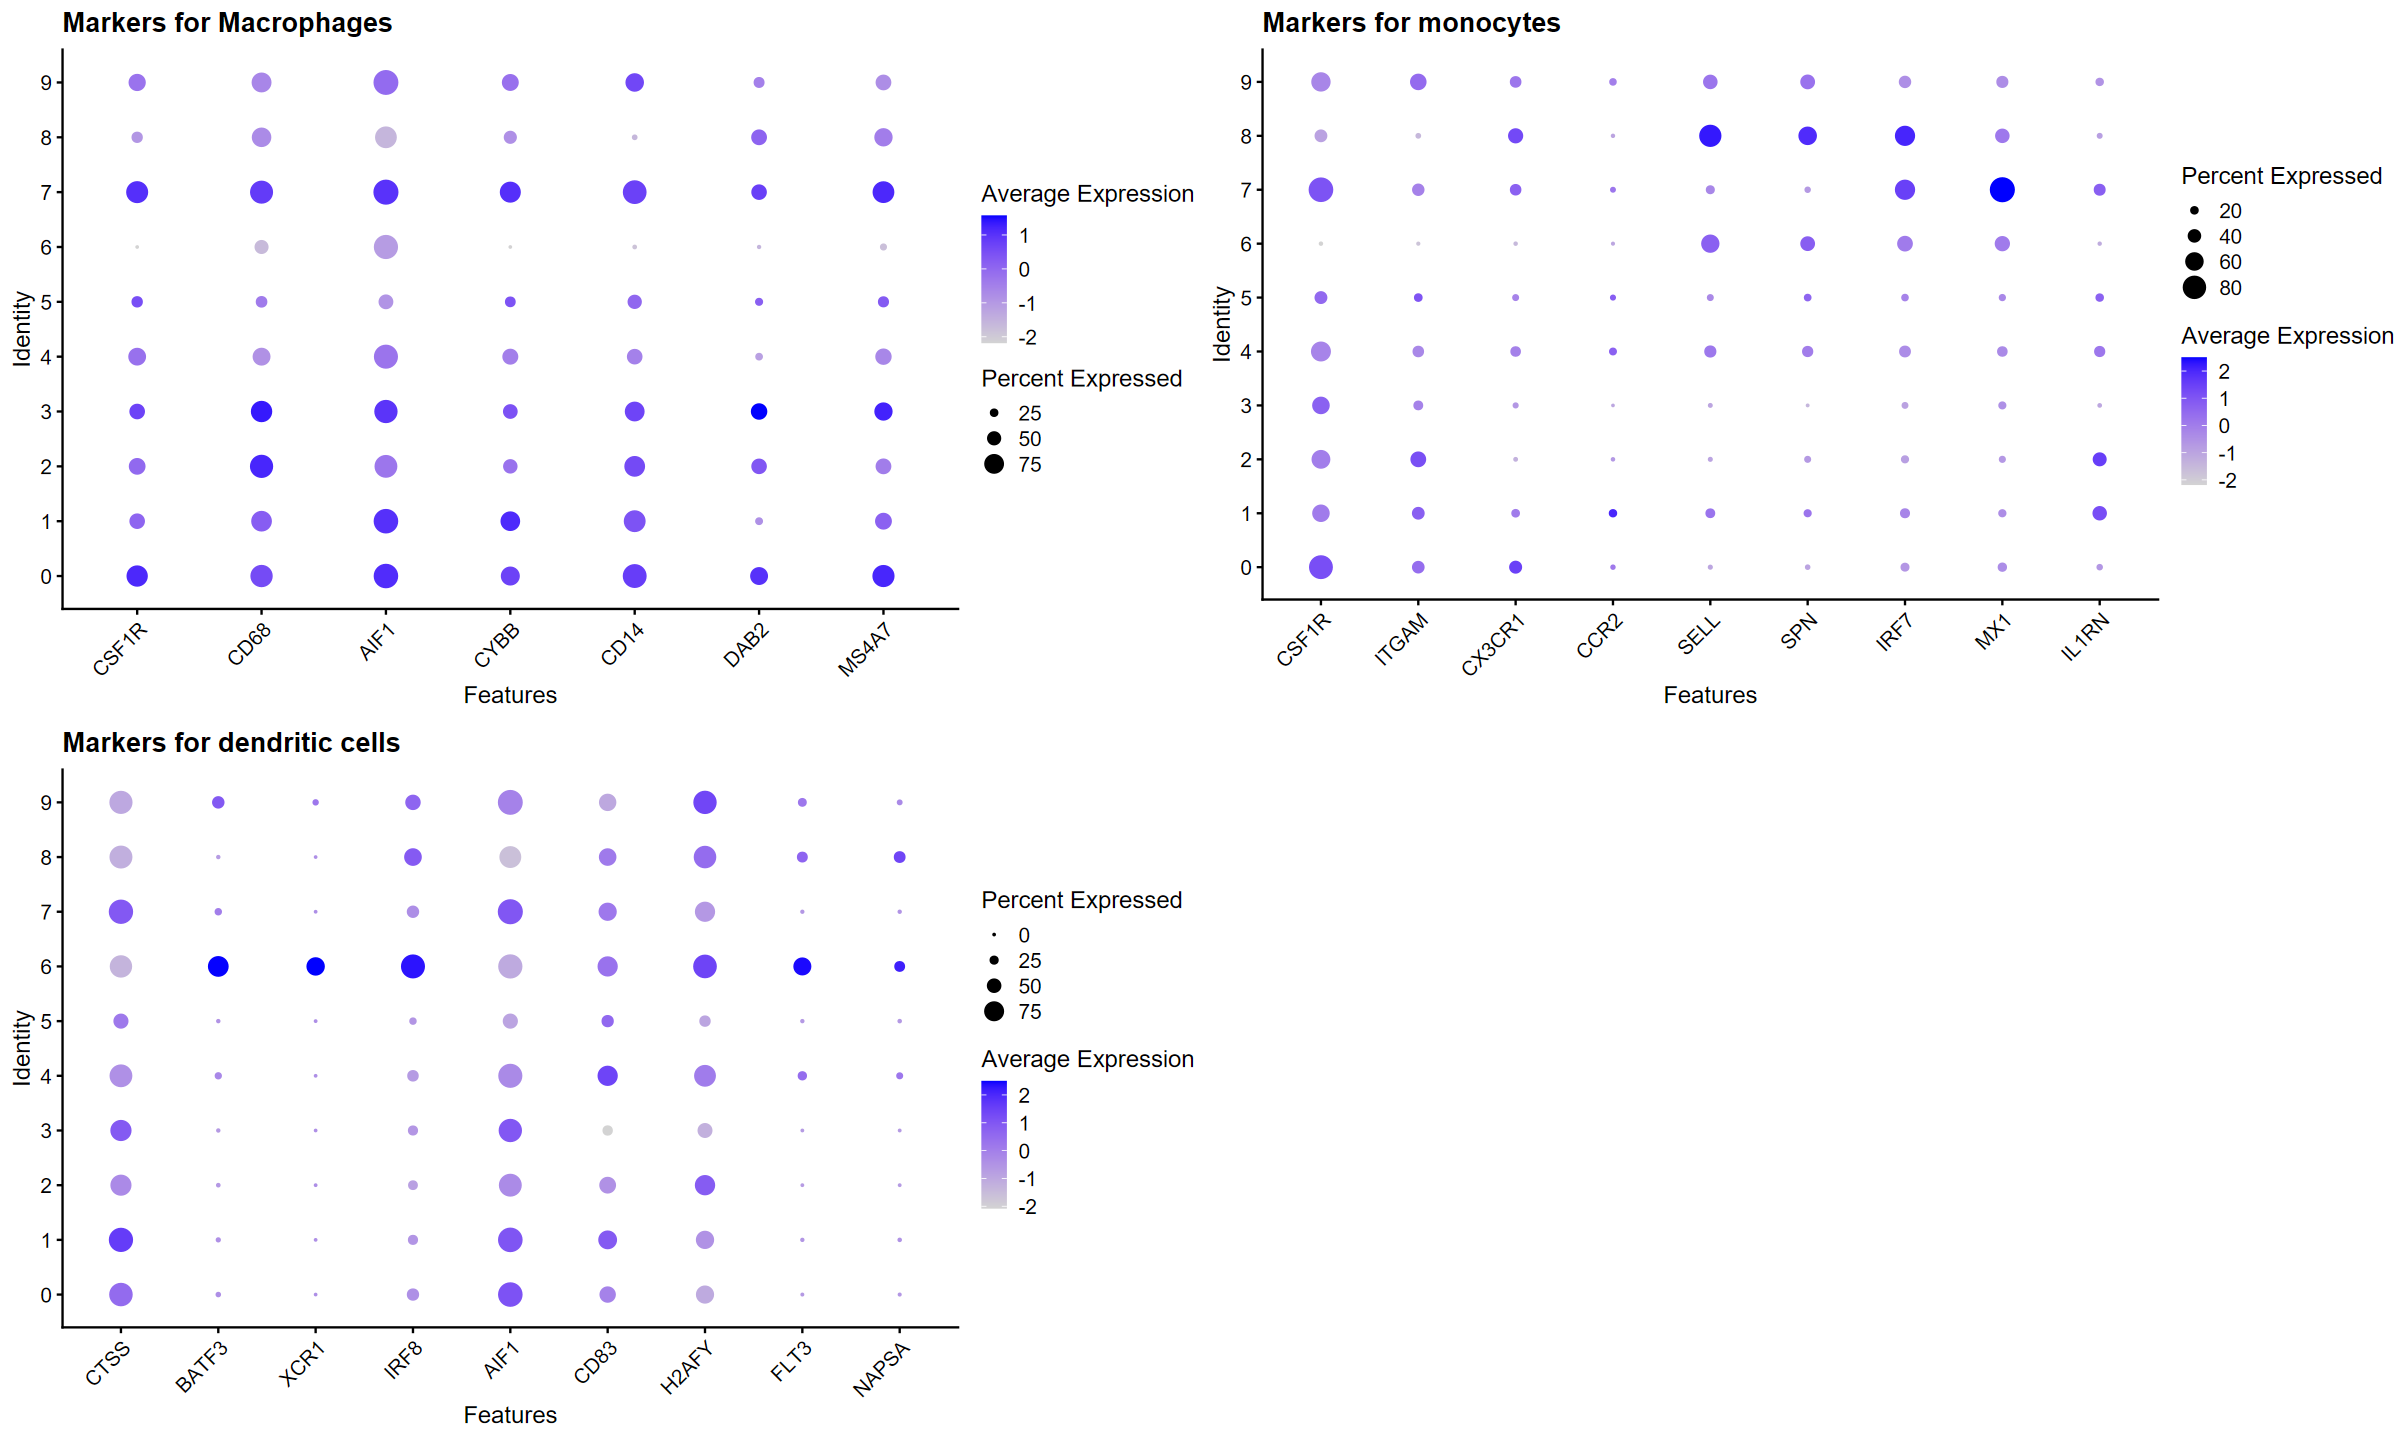

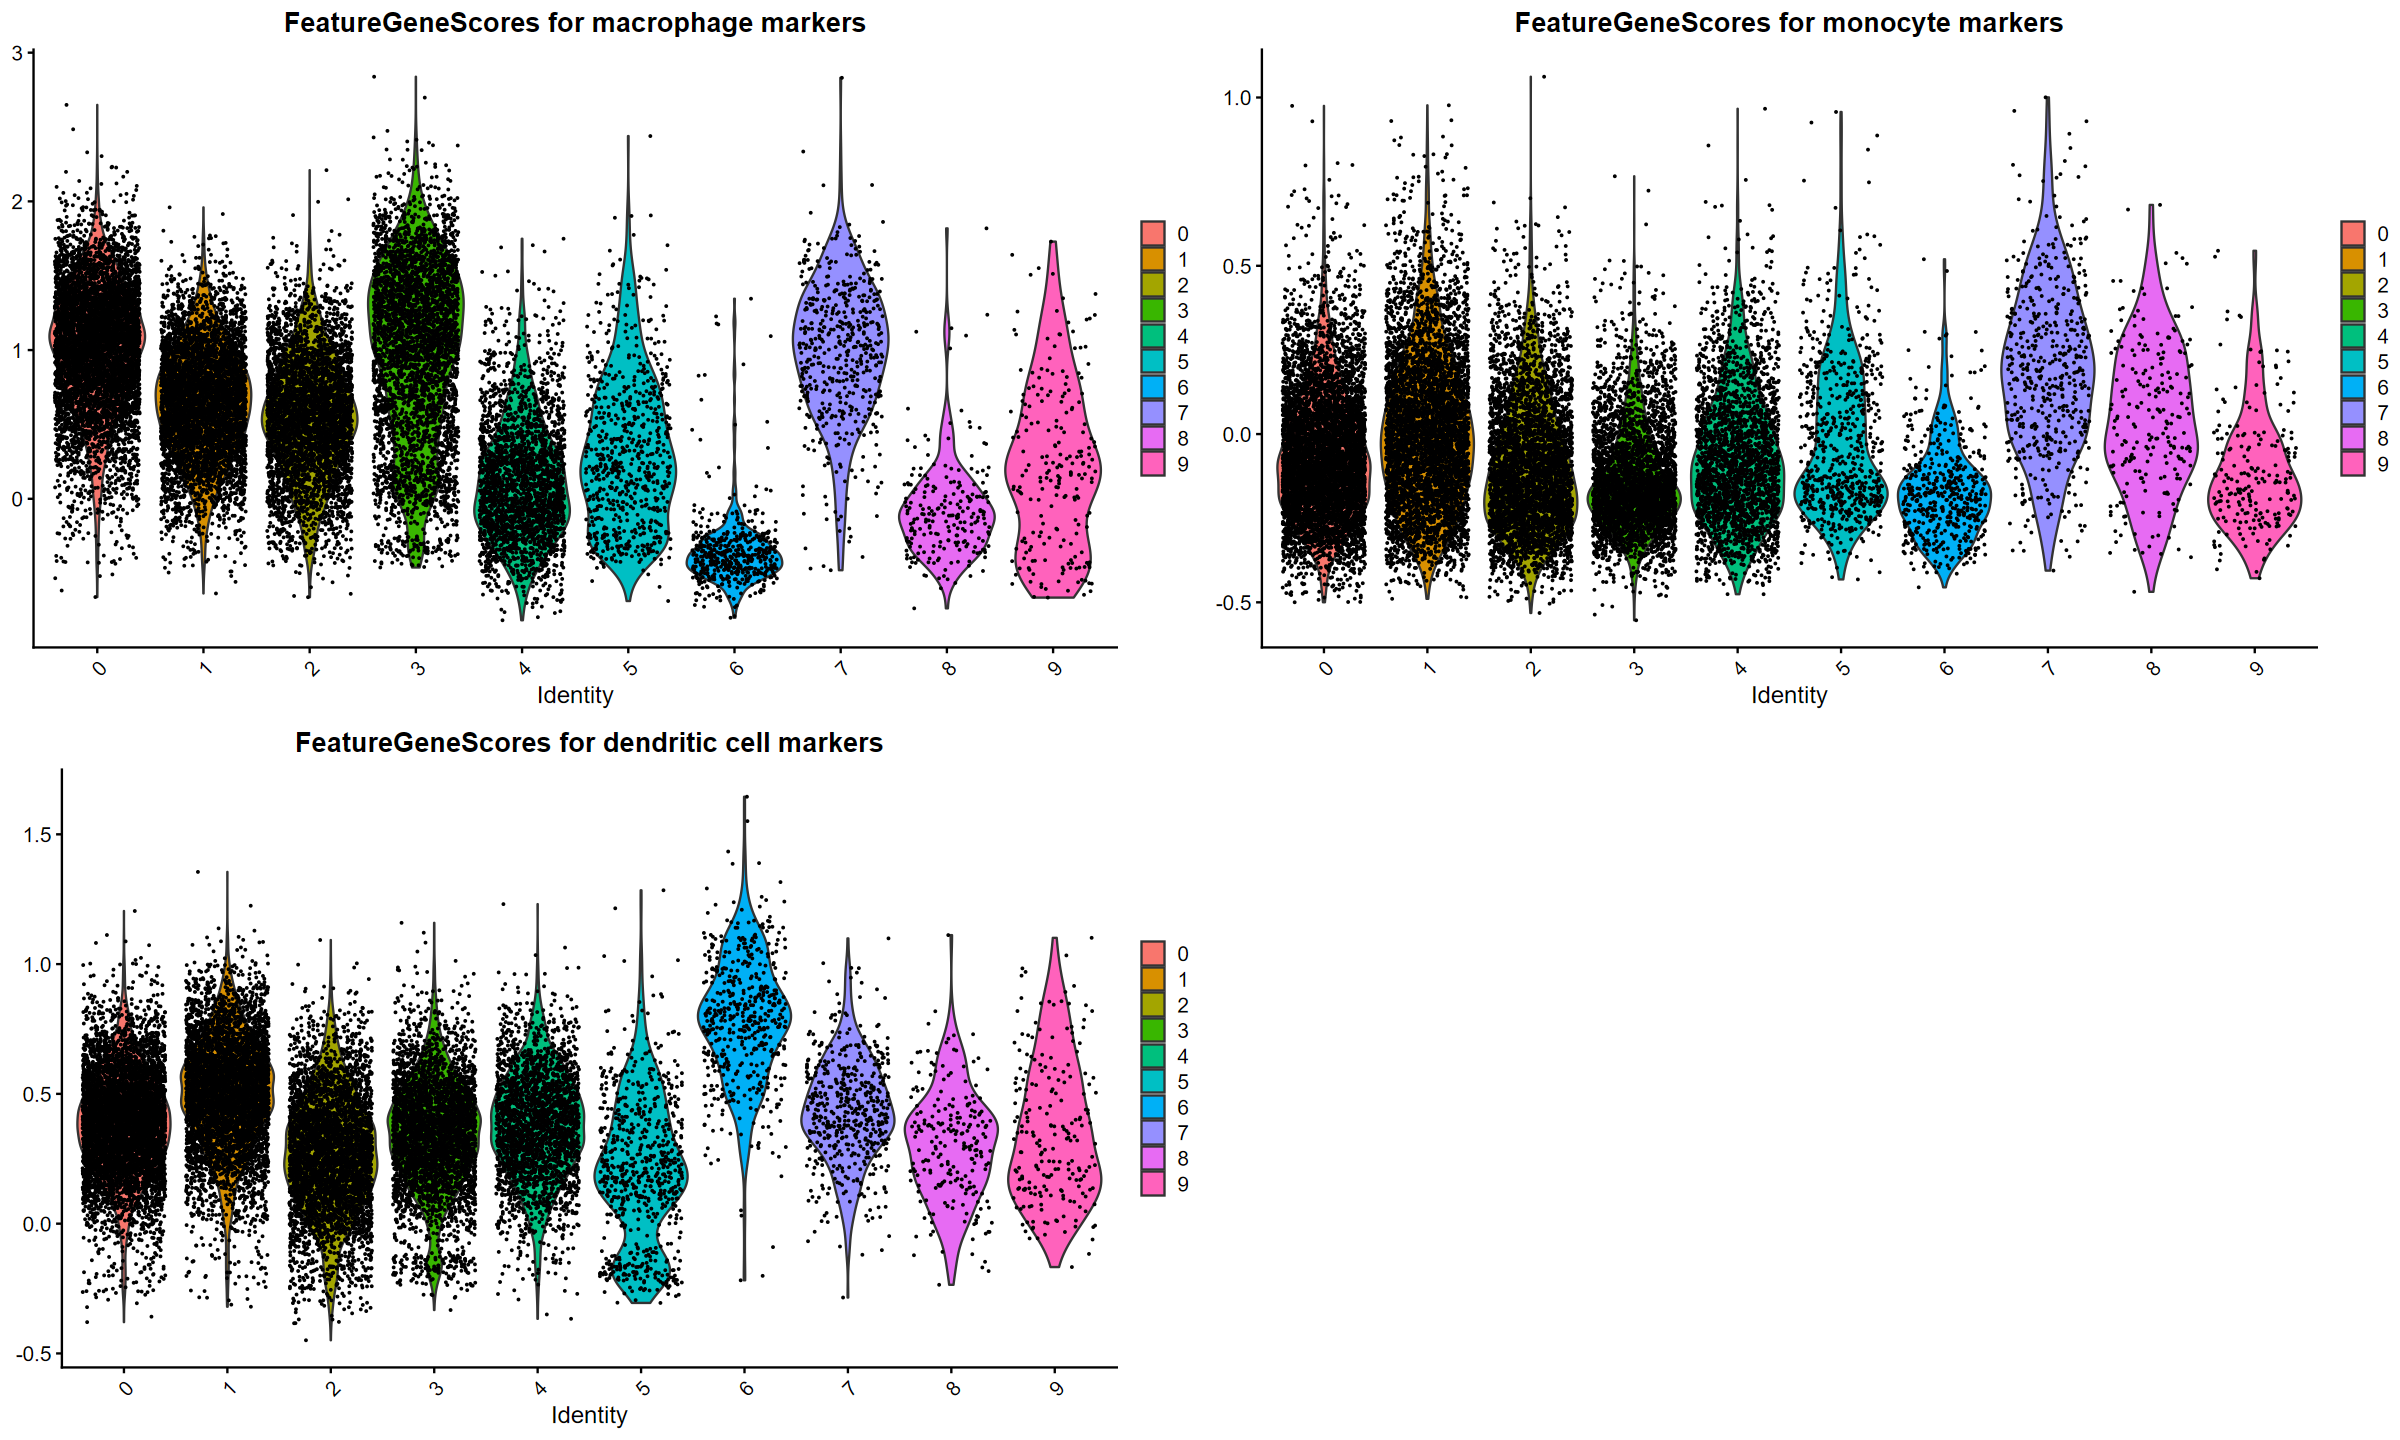

In [ ]:
# Dotplot of marker genes
grid.arrange(macrophage_dot, monocyte_dot, dc_dot, ncol = 2)
grid.arrange(macrophage_vln, monocyte_vln, dc_vln, ncol=2)

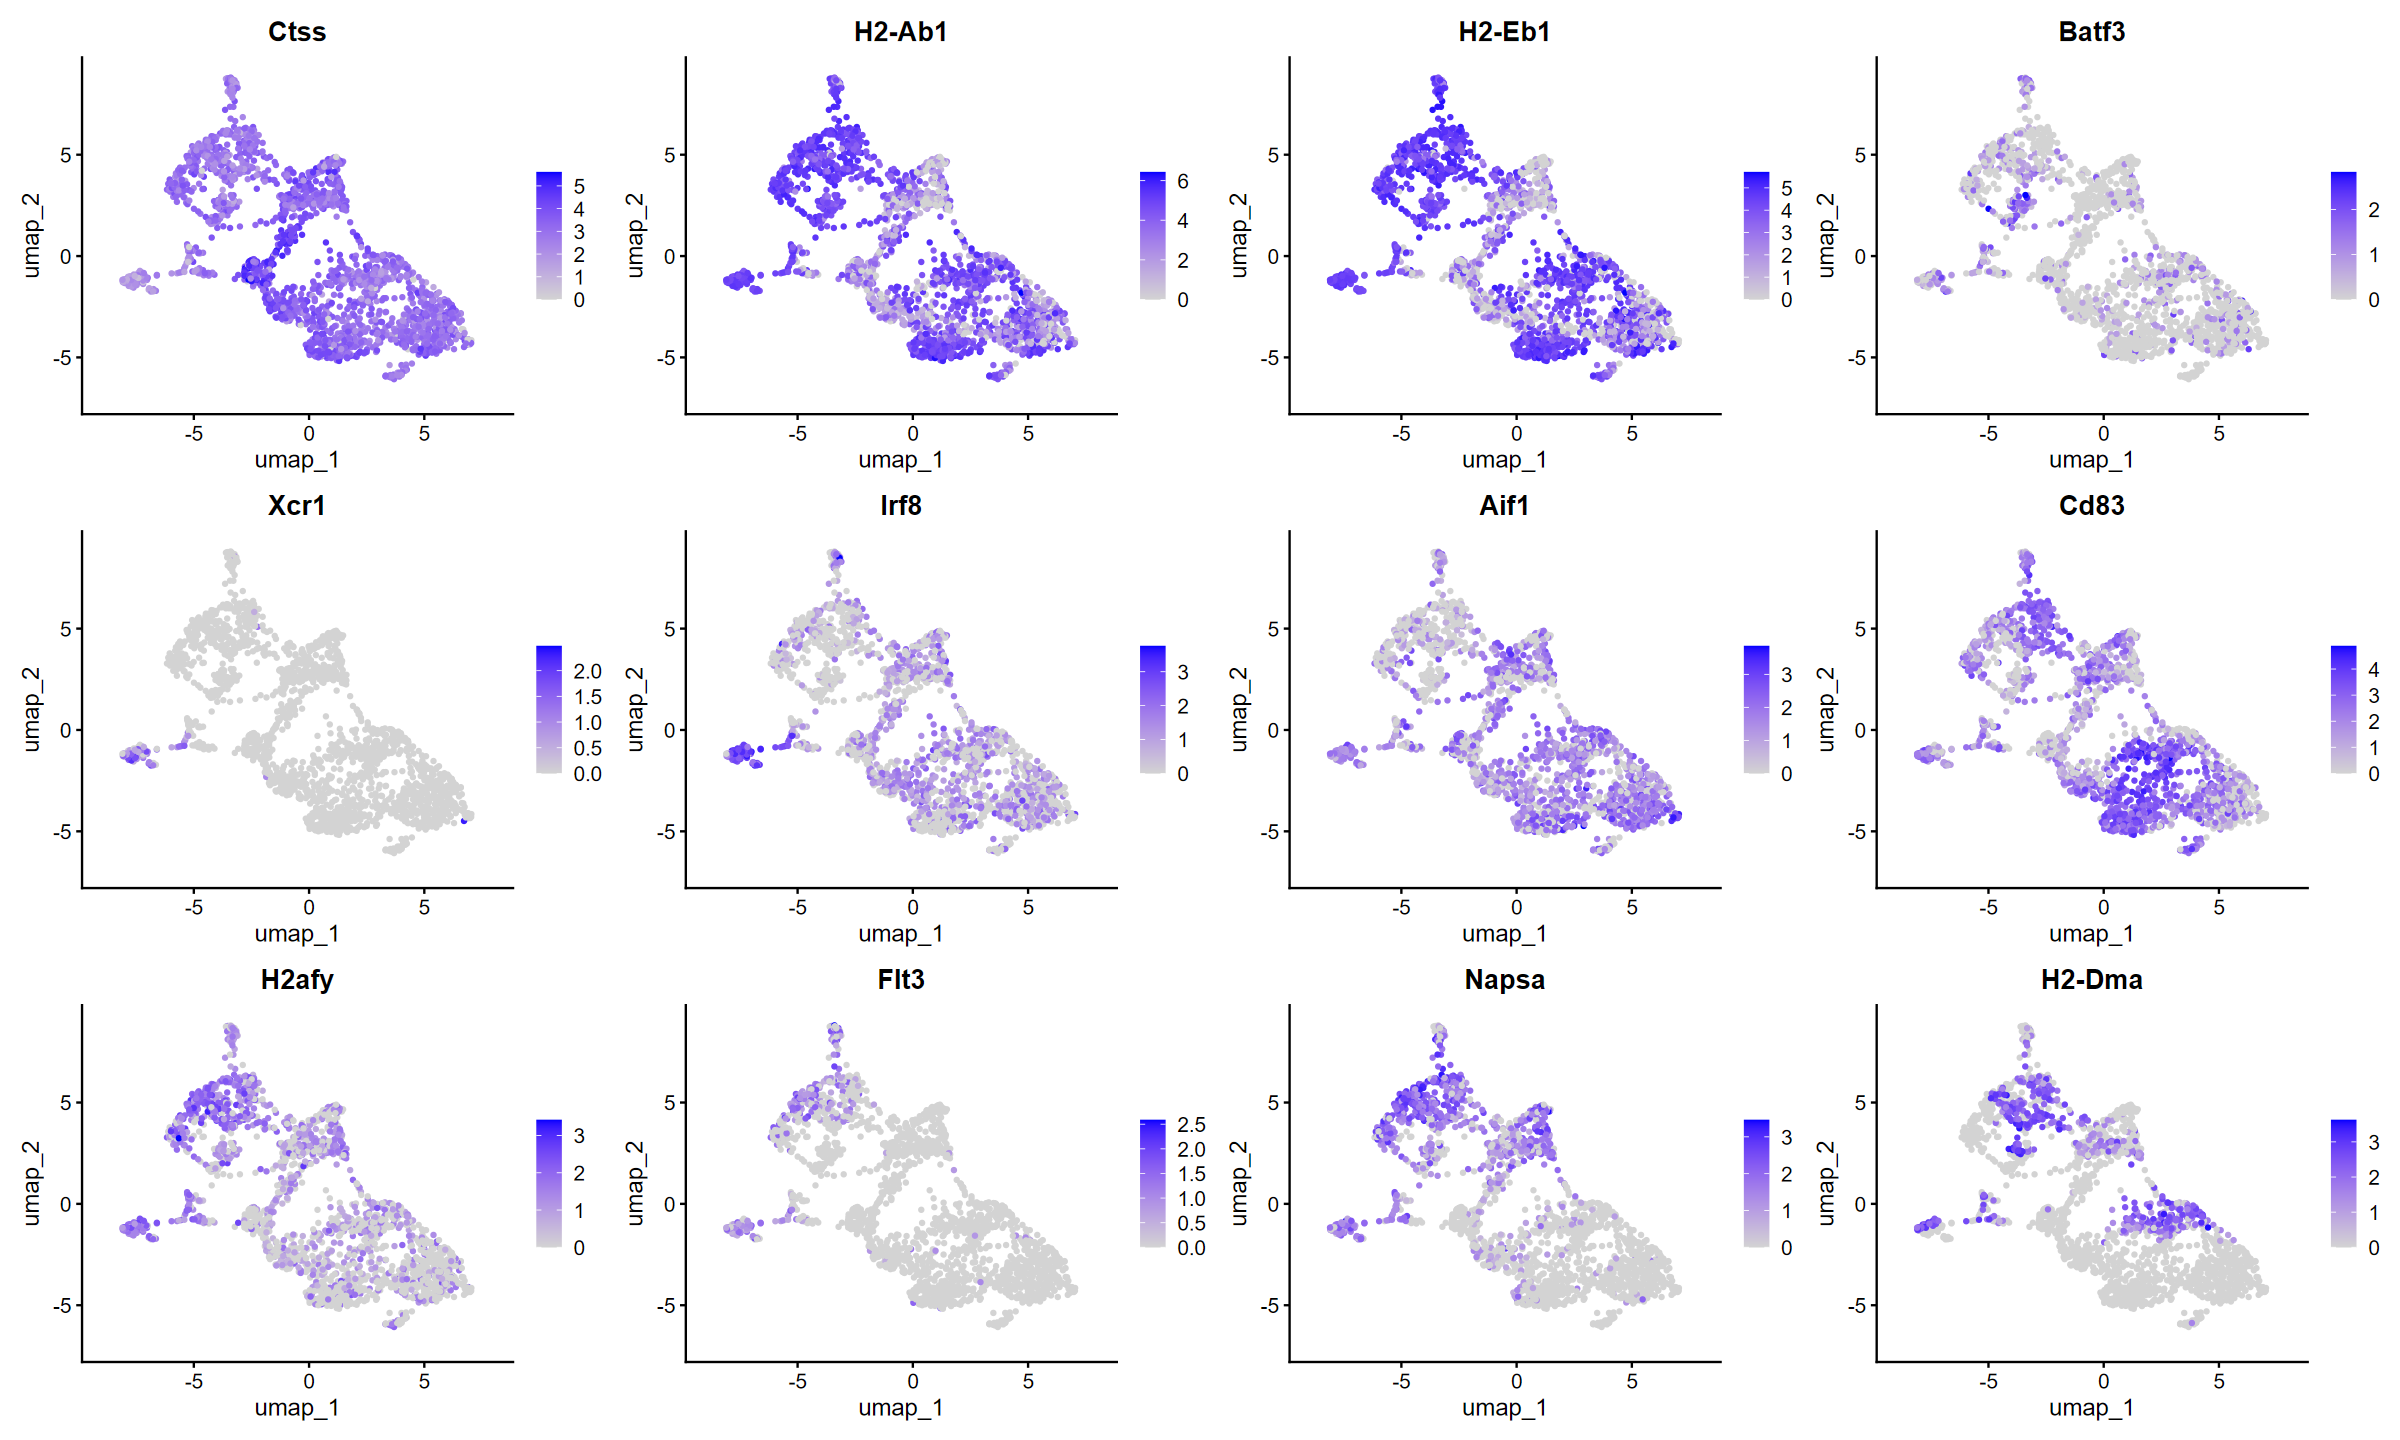

In [ ]:
# Featureplot of DC markers
FeaturePlot(myeloid_data, features = features_dcs)

In [377]:
# This cell block is needed to find the different markers between several clusters of which we dont know the identity
myeloid_data <- SetIdent(myeloid_data, value = "seurat_clusters")
markers <- FindMarkers(myeloid_data, ident.1 = "10", ident.2 = "0",  only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
markers %>%
  dplyr::filter(avg_log2FC > .75) %>%
  slice_head(n = 5) %>%
  ungroup() -> top10

# Markers
markers %>% filter(p_val_adj < 0.05) %>% slice_max(order_by = avg_log2FC, n = 8) %>% arrange(desc(pct.1))

p_val        avg_log2FC pct.1 pct.2 p_val_adj   
Ear2          1.536861e-90 8.334979   0.957 0.007 4.712323e-86
Upb1          5.822098e-60 9.389566   0.609 0.000 1.785172e-55
Rpl13-Ps3     1.689608e-53 9.106194   0.565 0.002 5.180678e-49
H2-Dmb2       2.194422e-53 9.981964   0.543 0.000 6.728537e-49
Ryr1          3.274099e-51 8.704667   0.522 0.000 1.003904e-46
Hr            6.848377e-47 8.342483   0.478 0.000 2.099849e-42
4930523c07rik 4.811014e-32 7.843038   0.326 0.000 1.475153e-27
Slc27a3       7.066749e-28 8.172339   0.283 0.000 2.166807e-23

In [ ]:
# OpenAI key
Sys.setenv(OPENAI_API_KEY = 'use your own key')

# Cell type annotation with GPT, for interest
res <- gptcelltype(
    markers, 
    tissuename = 'Atherosclerotic mouse aorta. Only macrophages, monocytes or dendritic cells.',
    model = 'gpt-4o')

# Assign cell type annotation back to Seurat object
myeloid_data@meta.data$celltype <- as.factor(res[as.character(Idents(myeloid_data))])

[1] "Note: OpenAI API key found: returning the cell type annotations."
[1] "Note: It is always recommended to check the results returned by GPT-4 in case of\n AI hallucination, before going to down-stream analysis."


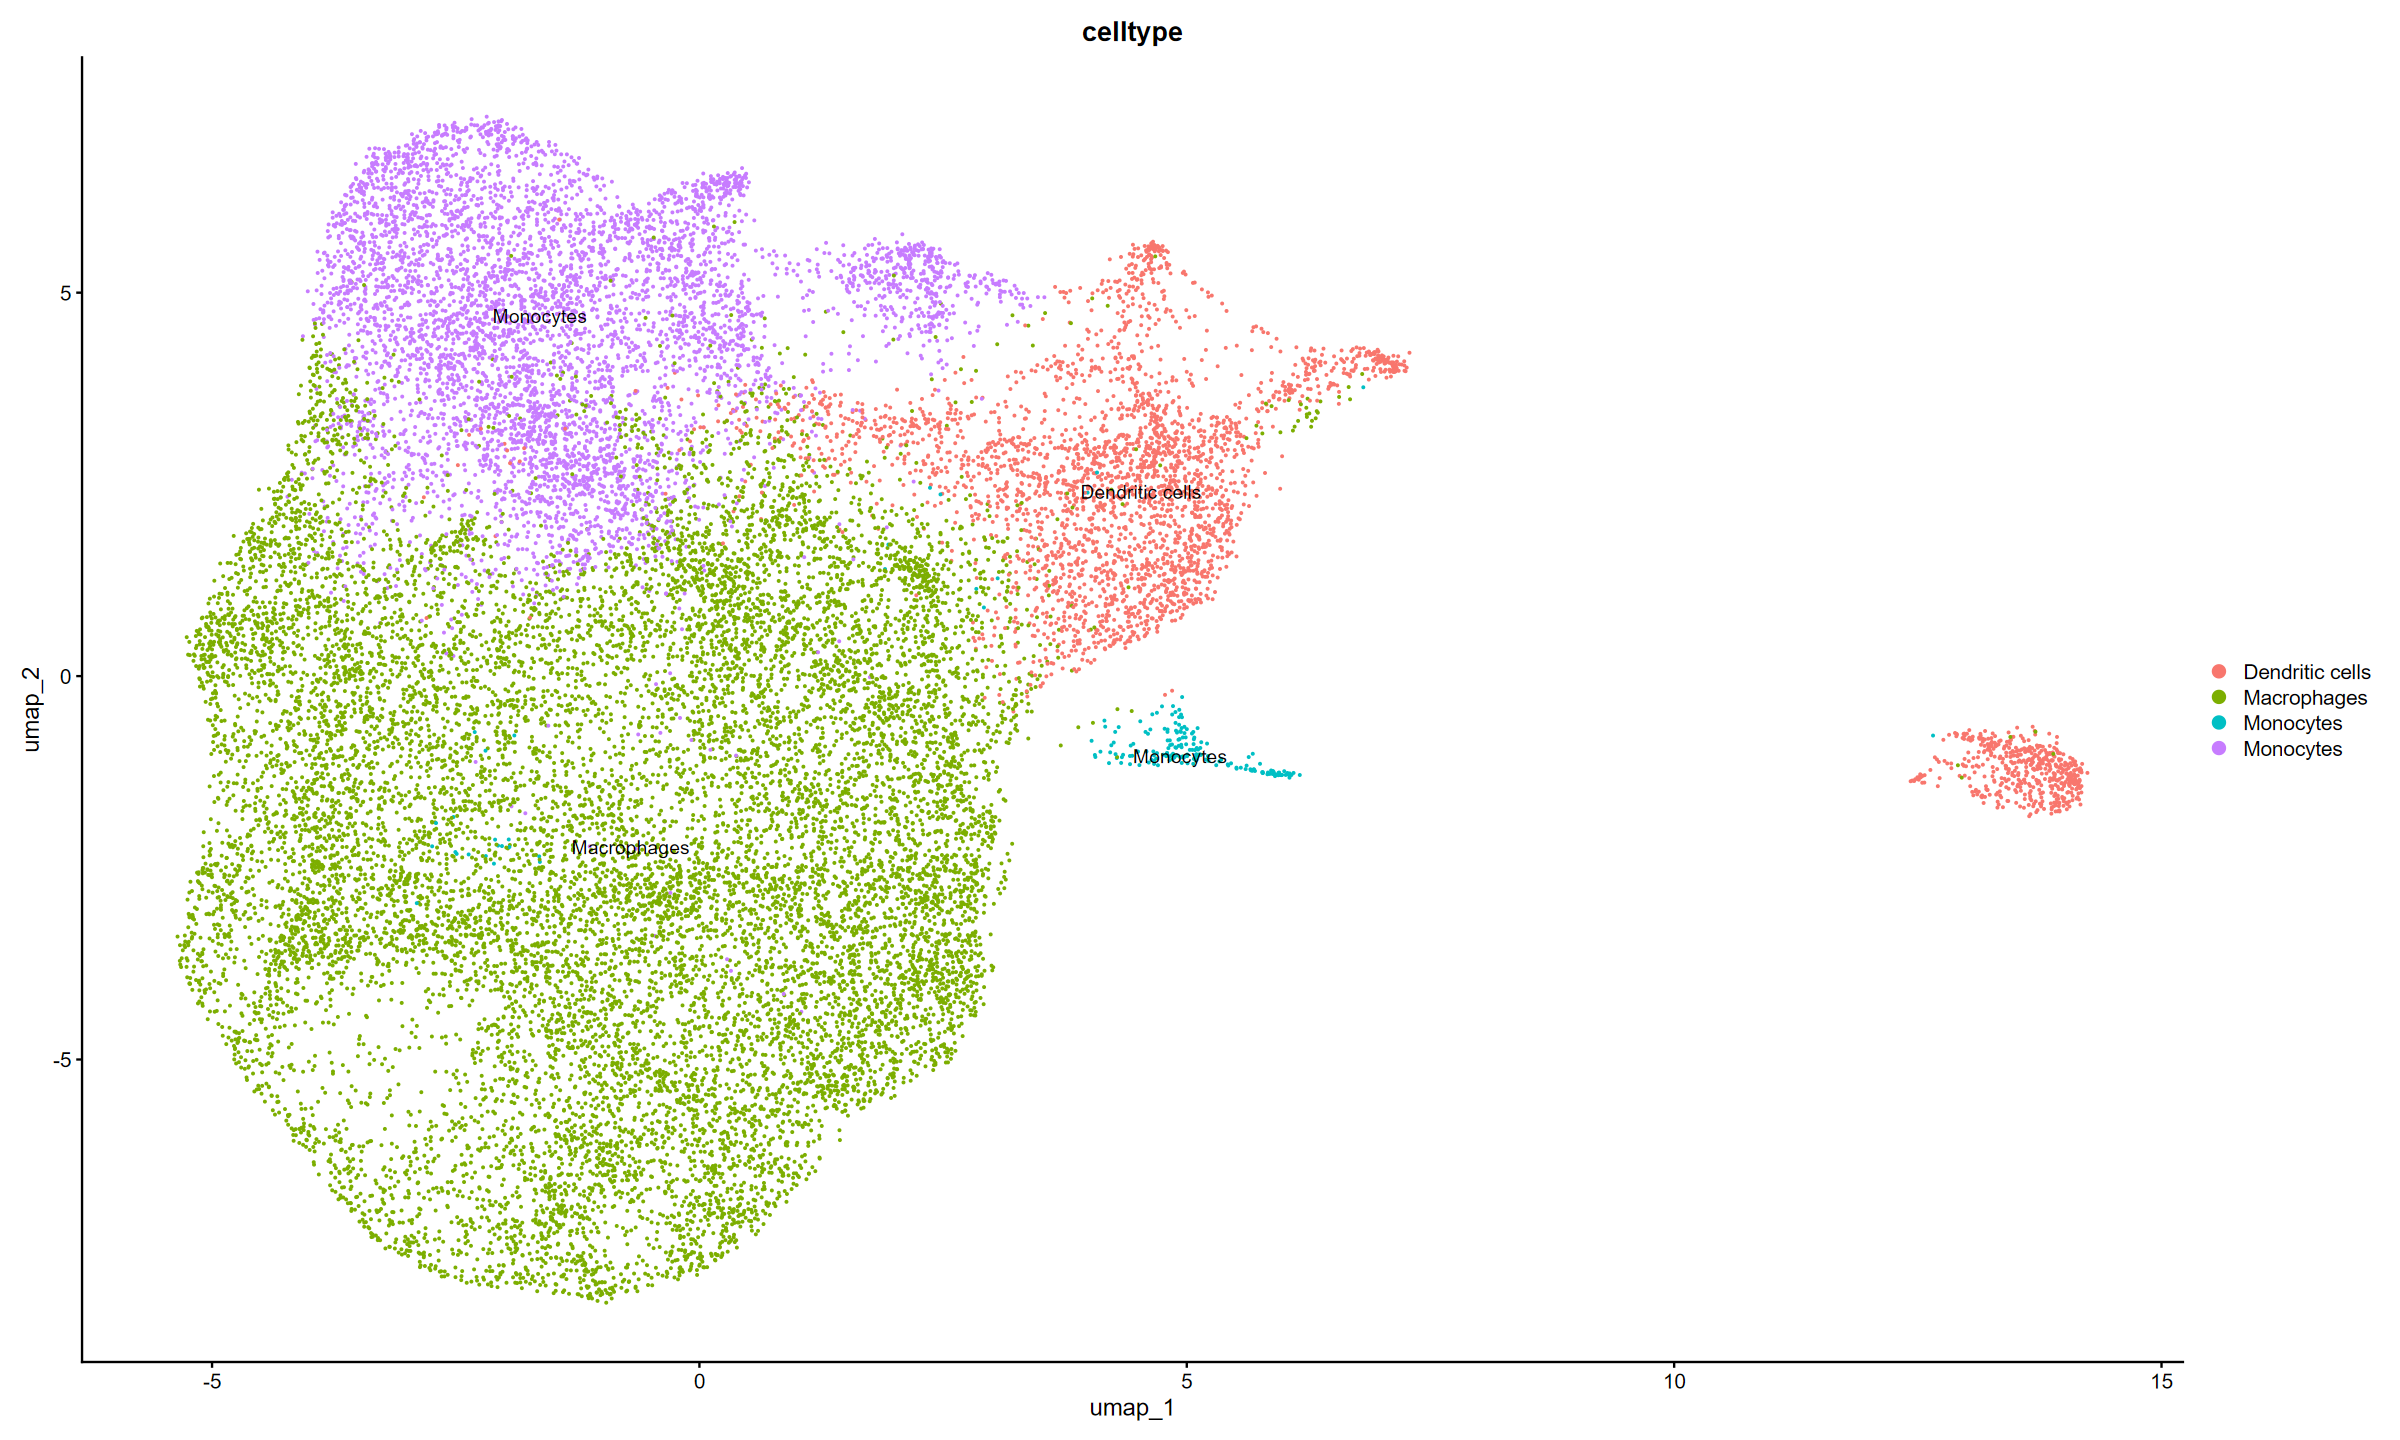

In [ ]:
# Visualize GPT cell type annotation on UMAP
DimPlot(myeloid_data, reduction="umap", group.by='celltype', label=TRUE)

In [ ]:
# Assign annotations of found DGE analysis
myeloid_data <- SetIdent(myeloid_data, value = "seurat_clusters")
myeloid_data <- RenameIdents(myeloid_data,
                                   '0' = 'Macrophages',
                                   '1' = 'Macrophages',
                                   '2' = 'Macrophages', 
                                   '3' = 'Macrophages',
                                   '4' = 'Dendritic cell',
                                   '5' = 'Mixture1',
                                   '6' = 'Dendritic cells',
                                   '7' = 'Monocytes',
                                   '8' = 'Dendritic cells',
                                   '9' = 'Mixture2/NA') 

myeloid_data$celltype2 <- Idents(myeloid_data)  # Save as metadata column



# Proportion tables
annotations_per_origin <- table(Idents(myeloid_data), myeloid_data$orig.ident)
annotations_per_origin_prop <- prop.table(table(Idents(myeloid_data), myeloid_data$orig.ident), margin = 2) * 100

# Subtype plots after annotation
subtype_annotated_plot <- DimPlot(myeloid_data, reduction = "umap", group.by="celltype2", label = TRUE)
subtype_origin_plot <- DimPlot(myeloid_data, reduction = "umap", group.by = "orig.ident", label = TRUE)


# Combine tables side by side
combined_df <- cbind(annotations_per_origin, annotations_per_origin_prop)

Bashore et al. (2024), 13 Bashore et al. (2024), P14
Macrophages     284                       872                       
Dendritic cell   17                        44                       
Mixture1         11                         3                       
Dendritic cells   9                         7                       
Monocytes         5                        41                       
Mixture2/NA       4                         5                       
                Bashore et al. (2024), P15 Bashore et al. (2024), P16
Macrophages     702                        1262                      
Dendritic cell   30                          51                      
Mixture1         18                          11                      
Dendritic cells   5                          10                      
Monocytes        24                          41                      
Mixture2/NA       2                          11                      
                Bashore et al. (2024), P17 Bashore et al. (2024), P18
Macrophages     900                        359                       
Dendritic cell   49                         19                       
Mixture1         22                         17                       
Dendritic cells  10                          5                       
Monocytes        40                         12                       
Mixture2/NA       9                          1                       
                Bashore et al. (2024), P19 Bashore et al. (2024), P20
Macrophages     895                        274                       
Dendritic cell   39                         24                       
Mixture1         64                         14                       
Dendritic cells  12                          8                       
Monocytes        32                          7                       
Mixture2/NA       4                          2                       
                Bashore et al. (2024), P21 Bashore et al. (2024), P4 ⋯
Macrophages     741                        212                       ⋯
Dendritic cell   55                         10                       ⋯
Mixture1         51                          2                       ⋯
Dendritic cells  13                          5                       ⋯
Monocytes        25                          6                       ⋯
Mixture2/NA       9                          0                       ⋯
                Fernandez et al. (2019), P3 Fernandez et al. (2019), P4
Macrophages     76.190476                   76.9633508                 
Dendritic cell  19.047619                   15.7068063                 
Mixture1         0.000000                    0.5235602                 
Dendritic cells  3.174603                    4.7120419                 
Monocytes        0.000000                    1.0471204                 
Mixture2/NA      1.587302                    1.0471204                 
                Fernandez et al. (2019), P5 Fernandez et al. (2019), P6
Macrophages     81.481481                   75.000000                  
Dendritic cell  13.580247                   16.071429                  
Mixture1         1.234568                    3.571429                  
Dendritic cells  3.703704                    3.571429                  
Monocytes        0.000000                    0.000000                  
Mixture2/NA      0.000000                    1.785714                  
                Horstmann et al. (2023), P3 Horstmann et al. (2023), P4
Macrophages     74.603175                   74.2474916                 
Dendritic cell  19.047619                   17.3913043                 
Mixture1         0.000000                    0.3344482                 
Dendritic cells  3.174603                    6.3545151                 
Monocytes        3.174603                    1.6722408                 
Mixture2/NA      0.000000                    0.0000000                 
                Horstmann et al. (2023), P5 Horstmann 

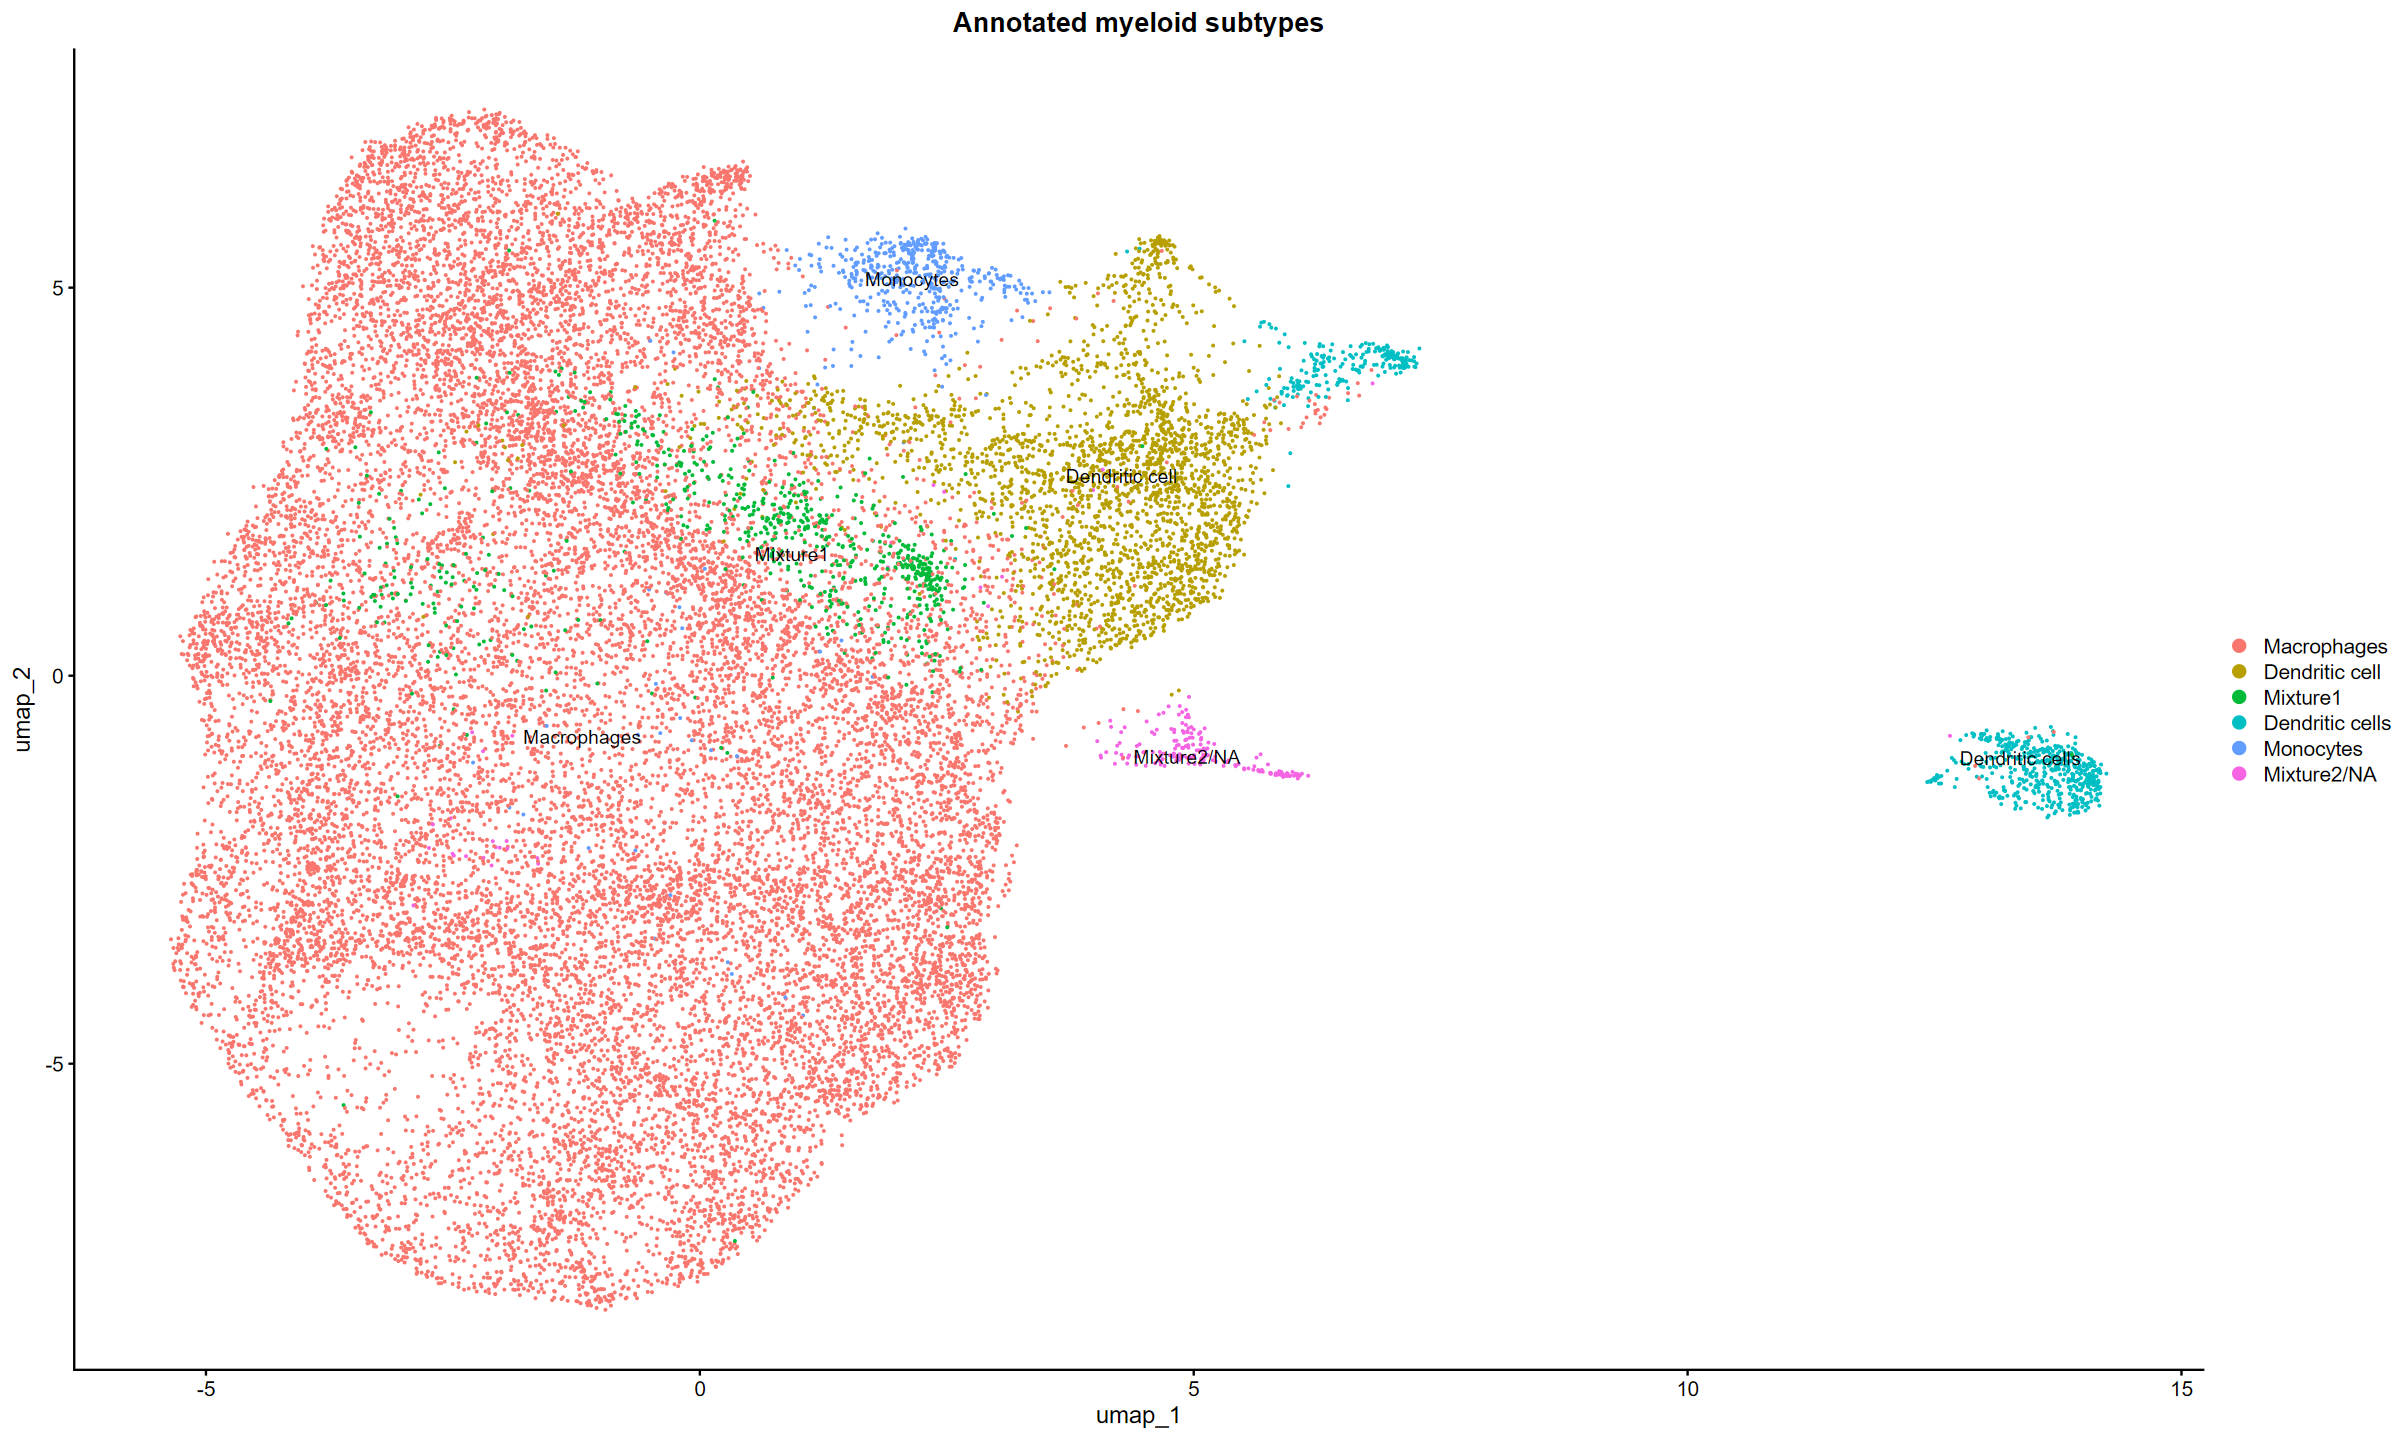

In [40]:
# Plot table
combined_df

# Plotting annotations and titles
grid.arrange(
    subtype_annotated_plot + ggtitle("Annotated myeloid subtypes")
    #subtype_origin_plot + ggtitle("DimPlot by origin")
    #ncol=1
)

In [ ]:
# View amount of macrophage cells according to low res annotation
ncol(subset(myeloid_data, subset = celltype2 == "Macrophages"))

[1] 18828

In [ ]:
# Subset macrophages
macrophage_data <- subset(myeloid_data, idents = "Macrophages")

In [ ]:
# Save results of low-res annotation
saveRDS(macrophage_data, "Myeloid_data_annotated.rds")